# QT-Assignment-03

by Guillaume IDAME KORALAGE

## Libraries
Let's import libraries we will need first.

In [1]:
import random
import numpy as np
!pip install hurst # delete if already installed
from hurst import compute_Hc
import matplotlib.pyplot as plt

ERROR: Invalid requirement: '#'


## Questions

The goal of this exercise is to get a flavor of order book modeling. You will simulate a simple particle model, close to the Bak et al. model and analyze the dynamics of mid-point price and bid-ask spread.

In [2]:
def simulate_diffusion(N, M, num_steps, p, print_interval=100):
    if N % 2 != 0:
        raise ValueError("N must be an even number for equal numbers of A and B particles")

    half_N = N // 2
    half_M = M // 2

    # Initialize lists for A and B particle positions with the desired intervals
    a_particle_positions = random.sample(range(half_M, M), half_N)
    b_particle_positions = random.sample(range(half_M), half_N)

    # Create a dictionary to keep track of particle counts at each lattice position
    particle_counts = {}

    # Initialize the particle counts based on initial positions
    for pos in a_particle_positions:
        particle_counts[pos] = ('A', particle_counts.get(pos, 0) + 1)
    for pos in b_particle_positions:
        particle_counts[pos] = ('B', particle_counts.get(pos, 0) + 1)

    mp_evol = []

    # Perform the diffusion simulation for num_steps
    for step in range(num_steps):
        # Shuffle the order in which particles move for both A and B
        random.shuffle(a_particle_positions)
        random.shuffle(b_particle_positions)


        most_right_b = max(b_particle_positions) if b_particle_positions else -1
        most_left_a = min(a_particle_positions) if a_particle_positions else -1
        midpoint  = 0.5*(most_right_b + most_left_a)
        mp_evol.append(midpoint)

        # Randomly select either A or B particle
        chosen_particle_type = random.choice(['A', 'B'])

        if chosen_particle_type == 'A':
            for i in range(len(a_particle_positions)):
                move = random.choices([-1, 0, 1], weights=[p, 1 - 2*p, p])[0]
                current_position = a_particle_positions[i]

                # Calculate the new position after the move without periodic boundary conditions
                new_position = current_position + move

                # Ensure the new position is within the lattice boundaries
                new_position = max(0, min(new_position, M - 1))

                #print('A',current_position, new_position, particle_counts.get(new_position, ('', 0))[0] )

                # Check if the new position is not already occupied by another A particle
                if particle_counts.get(new_position, ('', 0))[0] != 'A' or particle_counts.get(new_position, ('', 0))[1] == 0:
                    # Update the lattice position for the current A particle
                    a_particle_positions[i] = new_position
                    # Update particle_counts by decrementing the count at the old position
                    old_count = particle_counts.get(current_position, ('', 0))[1]
                    particle_counts[current_position] = ('A', old_count - 1)
                    # Update particle_counts by incrementing the count at the new position
                    new_count = particle_counts.get(new_position, ('', 0))[1]
                    particle_counts[new_position] = ('A', new_count + 1)

        else:
            for i in range(len(b_particle_positions)):
                move = random.choices([-1, 0, 1], weights=[p, 1 - 2*p, p])[0]
                current_position = b_particle_positions[i]

                # Calculate the new position after the move without periodic boundary conditions
                new_position = current_position + move

                # Ensure the new position is within the lattice boundaries
                new_position = max(0, min(new_position, M - 1))

                #print('B',current_position, new_position, particle_counts.get(new_position, ('', 0))[0] )

                # Check if the new position is not already occupied by another B particle
                if particle_counts.get(new_position, ('', 0))[0] != 'B' or particle_counts.get(new_position, ('', 0))[1] == 0:
                    # Update the lattice position for the current B particle
                    b_particle_positions[i] = new_position
                    # Update particle_counts by decrementing the count at the old position
                    old_count = particle_counts.get(current_position, ('', 0))[1]
                    particle_counts[current_position] = ('B', old_count - 1)
                    # Update particle_counts by incrementing the count at the new position
                    new_count = particle_counts.get(new_position, ('', 0))[1]
                    particle_counts[new_position] = ('B', new_count + 1)

        # Check for annihilation (A and B particles on the same site)
        a_positions_set = set(a_particle_positions)
        b_positions_set = set(b_particle_positions)
        common_positions = a_positions_set.intersection(b_positions_set)

        for pos in common_positions:
            a_count = a_particle_positions.count(pos)
            b_count = b_particle_positions.count(pos)

            if a_count > 0 and b_count > 0:
                # Annihilation occurs when there's at least one A and one B particle
                a_particle_positions.remove(pos)
                b_particle_positions.remove(pos)
                # Update particle_counts by removing the entry for the annihilated position
                del particle_counts[pos]
                #print("Trade at",pos)
                # insert new particles to avoid depletion
                k=0
                while(particle_counts.get(k, ('', 0))[1]>0):
                  k = k + 1
                particle_counts[k] = ('B',1)
                b_particle_positions.append(k)

                k=M-1
                while(particle_counts.get(k, ('', 0))[1]>0):
                  k = k - 1
                particle_counts[k] = ('A',1)
                a_particle_positions.append(k)


    #print(a_particle_positions)
    #print(b_particle_positions)
    return mp_evol

In [3]:
# Example usage:
N = 80 # Total number of particles (half will be A and half will be B)
M = 200  # Size of the 1D lattice
num_steps = 10000  # Number of simulation steps
p = 0.3  # Probability of left/right movement

mp_evol = simulate_diffusion(N, M, num_steps, p, print_interval=1)

### Q1: Consider the following particle model. What are the differences with respect to the model of Per Bak discussed?

Differences in the Provided Particle Model:

**Particle Movement**:
The provided particle model involves the random movement of particles (A and B) on a 1D lattice, and annihilation occurs when particles A and B occupy the same lattice position.

**Annihilation Process**:
Unlike the BTW model, where avalanches are triggered by exceeding a threshold, the provided model has an annihilation process when particles A and B are at the same position. The annihilation leads to the removal of particles and the introduction of new particles to avoid depletion.

**Continuous Evolution**:
The provided particle model doesn't exhibit the discrete avalanche dynamics seen in the BTW model. Instead, it involves continuous particle movement and annihilation.

**Midpoint Calculation**:
The midpoint between the rightmost B particle and the leftmost A particle is calculated and recorded at each step in the provided model, providing a measure of system evolution.

In summary, while both models involve particles and lattice-based dynamics, the specific mechanisms, objectives, and emergent behaviors differ. The BTW model is known for its criticality and power-law behavior during sandpile dynamics, whereas the provided model focuses on continuous particle movement and annihilation with a midpoint calculation as a measure of system state.

### Q2: Plot the evolution of the midprice (mp_evol). What do you notice ?

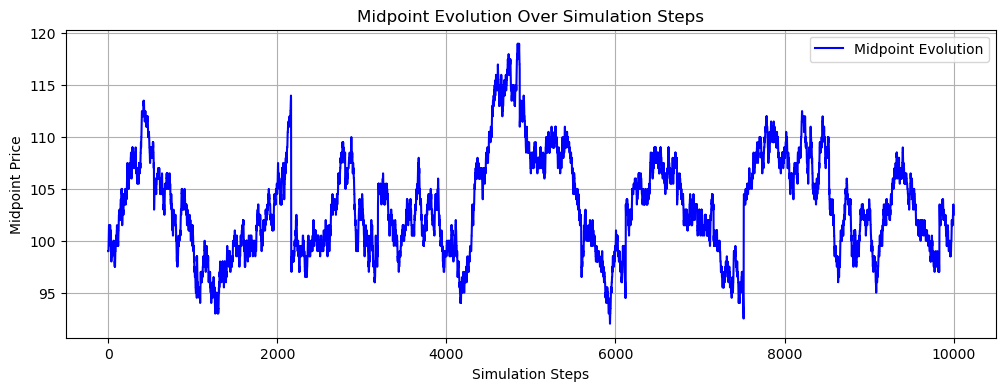

In [4]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(mp_evol, label='Midpoint Evolution', color='blue')
ax.set_title('Midpoint Evolution Over Simulation Steps')
ax.set_xlabel('Simulation Steps')
ax.set_ylabel('Midpoint Price')
ax.legend()
ax.grid(True)

The midprice evolution exhibits some random fluctuations with the majority of the points between 80-120. It may also be a stationary process in the LR.

### Q3: Calculate the variogram and signature plot discussed in the first lecture.

In [5]:
# Calculate variogram and signature 
lags = range(1,   len(mp_evol))
variogram = [np.mean((np.array(mp_evol[:-lag]) - np.array(mp_evol[lag:]))**2) for lag in lags]
signature = np.sqrt(variogram)/(lags*np.array(mp_evol[1:])**2)

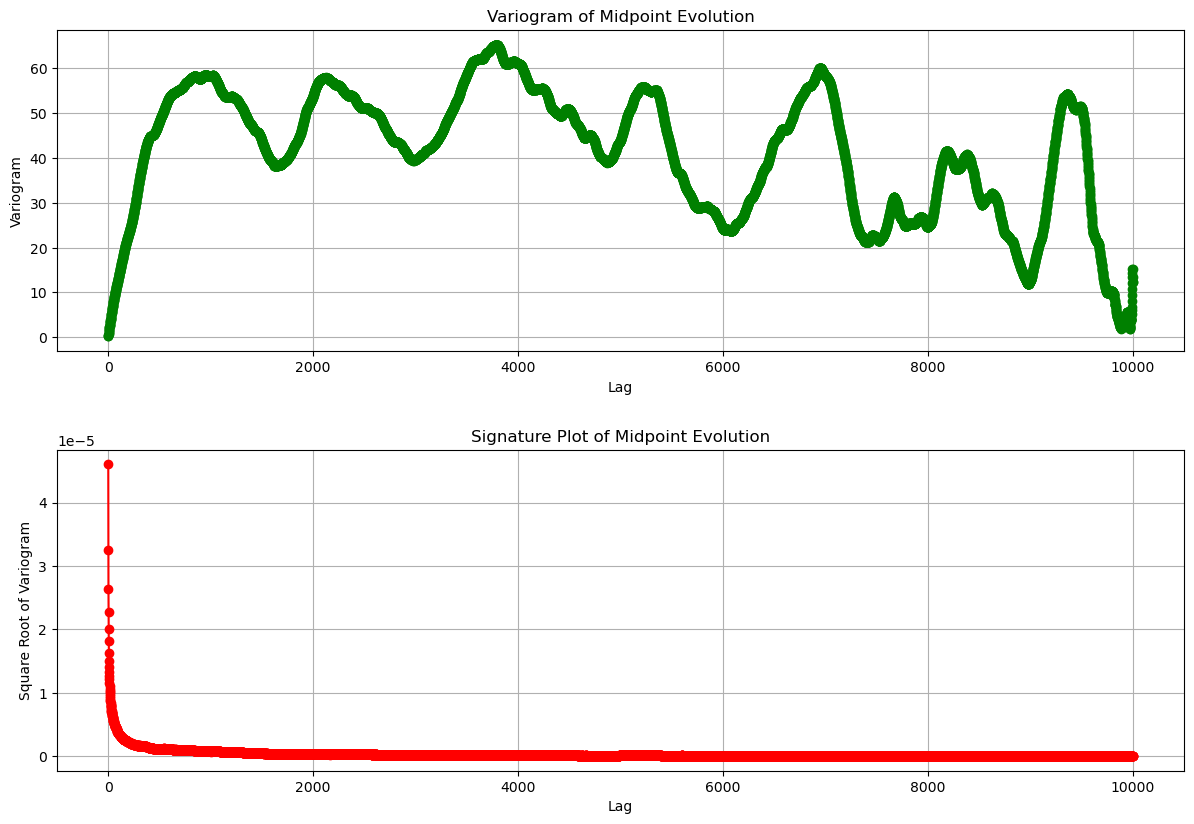

In [19]:
# Plot variogram
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
fig.tight_layout(h_pad = 5)
axs[0].plot(lags, variogram, marker='o', linestyle='-', color='green')
axs[0].set_title('Variogram of Midpoint Evolution')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Variogram')
axs[0].grid(True)

axs[1].plot(lags, signature, marker='o', linestyle='-', color='red')
axs[1].set_title('Signature Plot of Midpoint Evolution')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Square Root of Variogram')
axs[1].grid(True)

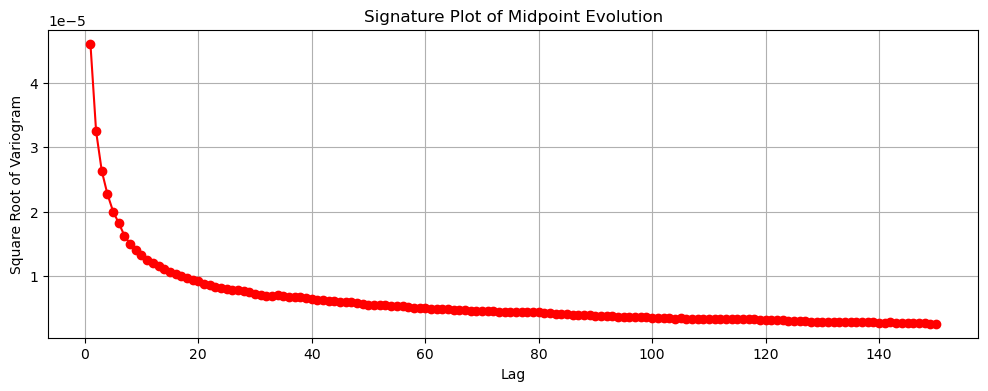

In [15]:
# Zoom
zoom_signature = signature[:150]

# Plot the signature plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(lags[:150], zoom_signature, marker='o', linestyle='-', color='red')
ax.set_title('Signature Plot of Midpoint Evolution')
ax.set_xlabel('Lag')
ax.set_ylabel('Square Root of Variogram')
ax.grid(True)

### Q4: Estimate the Hurst exponent.

In [8]:
# Convert mp_evol to a NumPy array
data = np.array(mp_evol)

# Compute the Hurst exponent
H, c, data_range = compute_Hc(data, kind='price', simplified=True)

# Print the estimated Hurst exponent
print(f'Hurst Exponent (H): {H:.4f}')

Hurst Exponent (H): 0.4365


### Q5: Modify the code, such that it also outputs the evolution of the spread. Plot the timeseries. What do you notice?

In [9]:
def simulate_diffusion(N, M, num_steps, p, print_interval=100):
    if N % 2 != 0:
        raise ValueError("N must be an even number for equal numbers of A and B particles")

    half_N = N // 2
    half_M = M // 2

    # Initialize lists for A and B particle positions with the desired intervals
    a_particle_positions = random.sample(range(half_M, M), half_N)
    b_particle_positions = random.sample(range(half_M), half_N)

    # Create a dictionary to keep track of particle counts at each lattice position
    particle_counts = {}

    # Initialize the particle counts based on initial positions
    for pos in a_particle_positions:
        particle_counts[pos] = ('A', particle_counts.get(pos, 0) + 1)
    for pos in b_particle_positions:
        particle_counts[pos] = ('B', particle_counts.get(pos, 0) + 1)

    mp_evol = []
    spread_evol = []
    # Perform the diffusion simulation for num_steps
    for step in range(num_steps):
        # Shuffle the order in which particles move for both A and B
        random.shuffle(a_particle_positions)
        random.shuffle(b_particle_positions)


        most_right_b = max(b_particle_positions) if b_particle_positions else -1
        most_left_a = min(a_particle_positions) if a_particle_positions else -1
        midpoint  = 0.5*(most_right_b + most_left_a)
        mp_evol.append(midpoint)
        # Calculate spread based on the best bid and ask prices
        best_bid = max(b_particle_positions) if b_particle_positions else 0
        best_ask = min(a_particle_positions) if a_particle_positions else M - 1
        spread = best_ask - best_bid
        spread_evol.append(spread)
        
        # Randomly select either A or B particle
        chosen_particle_type = random.choice(['A', 'B'])

        if chosen_particle_type == 'A':
            for i in range(len(a_particle_positions)):
                move = random.choices([-1, 0, 1], weights=[p, 1 - 2*p, p])[0]
                current_position = a_particle_positions[i]

                # Calculate the new position after the move without periodic boundary conditions
                new_position = current_position + move

                # Ensure the new position is within the lattice boundaries
                new_position = max(0, min(new_position, M - 1))

                #print('A',current_position, new_position, particle_counts.get(new_position, ('', 0))[0] )

                # Check if the new position is not already occupied by another A particle
                if particle_counts.get(new_position, ('', 0))[0] != 'A' or particle_counts.get(new_position, ('', 0))[1] == 0:
                    # Update the lattice position for the current A particle
                    a_particle_positions[i] = new_position
                    # Update particle_counts by decrementing the count at the old position
                    old_count = particle_counts.get(current_position, ('', 0))[1]
                    particle_counts[current_position] = ('A', old_count - 1)
                    # Update particle_counts by incrementing the count at the new position
                    new_count = particle_counts.get(new_position, ('', 0))[1]
                    particle_counts[new_position] = ('A', new_count + 1)

        else:
            for i in range(len(b_particle_positions)):
                move = random.choices([-1, 0, 1], weights=[p, 1 - 2*p, p])[0]
                current_position = b_particle_positions[i]

                # Calculate the new position after the move without periodic boundary conditions
                new_position = current_position + move

                # Ensure the new position is within the lattice boundaries
                new_position = max(0, min(new_position, M - 1))

                #print('B',current_position, new_position, particle_counts.get(new_position, ('', 0))[0] )

                # Check if the new position is not already occupied by another B particle
                if particle_counts.get(new_position, ('', 0))[0] != 'B' or particle_counts.get(new_position, ('', 0))[1] == 0:
                    # Update the lattice position for the current B particle
                    b_particle_positions[i] = new_position
                    # Update particle_counts by decrementing the count at the old position
                    old_count = particle_counts.get(current_position, ('', 0))[1]
                    particle_counts[current_position] = ('B', old_count - 1)
                    # Update particle_counts by incrementing the count at the new position
                    new_count = particle_counts.get(new_position, ('', 0))[1]
                    particle_counts[new_position] = ('B', new_count + 1)

        # Check for annihilation (A and B particles on the same site)
        a_positions_set = set(a_particle_positions)
        b_positions_set = set(b_particle_positions)
        common_positions = a_positions_set.intersection(b_positions_set)

        for pos in common_positions:
            a_count = a_particle_positions.count(pos)
            b_count = b_particle_positions.count(pos)

            if a_count > 0 and b_count > 0:
                # Annihilation occurs when there's at least one A and one B particle
                a_particle_positions.remove(pos)
                b_particle_positions.remove(pos)
                # Update particle_counts by removing the entry for the annihilated position
                del particle_counts[pos]
                #print("Trade at",pos)
                # insert new particles to avoid depletion
                k=0
                while(particle_counts.get(k, ('', 0))[1]>0):
                  k = k + 1
                particle_counts[k] = ('B',1)
                b_particle_positions.append(k)

                k=M-1
                while(particle_counts.get(k, ('', 0))[1]>0):
                  k = k - 1
                particle_counts[k] = ('A',1)
                a_particle_positions.append(k)


    #print(a_particle_positions)
    #print(b_particle_positions)
    return mp_evol, spread_evol

In [10]:
# Example usage
N = 80  # Total number of particles (half will be A and half will be B)
M = 200  # Size of the 1D lattice
num_steps = 10000  # Number of simulation steps
p = 0.3  # Probability of left/right movement

# Call the simulation function
mp_evol, spread_evol = simulate_diffusion(N, M, num_steps, p, print_interval=1)

# Convert lists to NumPy arrays for plotting
mp_array = np.array(mp_evol)
spread_array = np.array(spread_evol)

# Compute the Hurst exponent for both midprice and spread
try:
    H_mp, _, _ = compute_Hc(mp_array, kind='price', simplified=True)
    print(f'Hurst Exponent for Midpoint (H): {H_mp:.4f}')
except FloatingPointError:
    print("Error calculating Hurst exponent for Midpoint.")

try:
    H_spread, _, _ = compute_Hc(spread_array, kind='price', simplified=True)
    print(f'Hurst Exponent for Spread (H): {H_spread:.4f}')
except FloatingPointError:
    print("Error calculating Hurst exponent for Spread.")

Hurst Exponent for Midpoint (H): 0.4564
Hurst Exponent for Spread (H): 0.3733


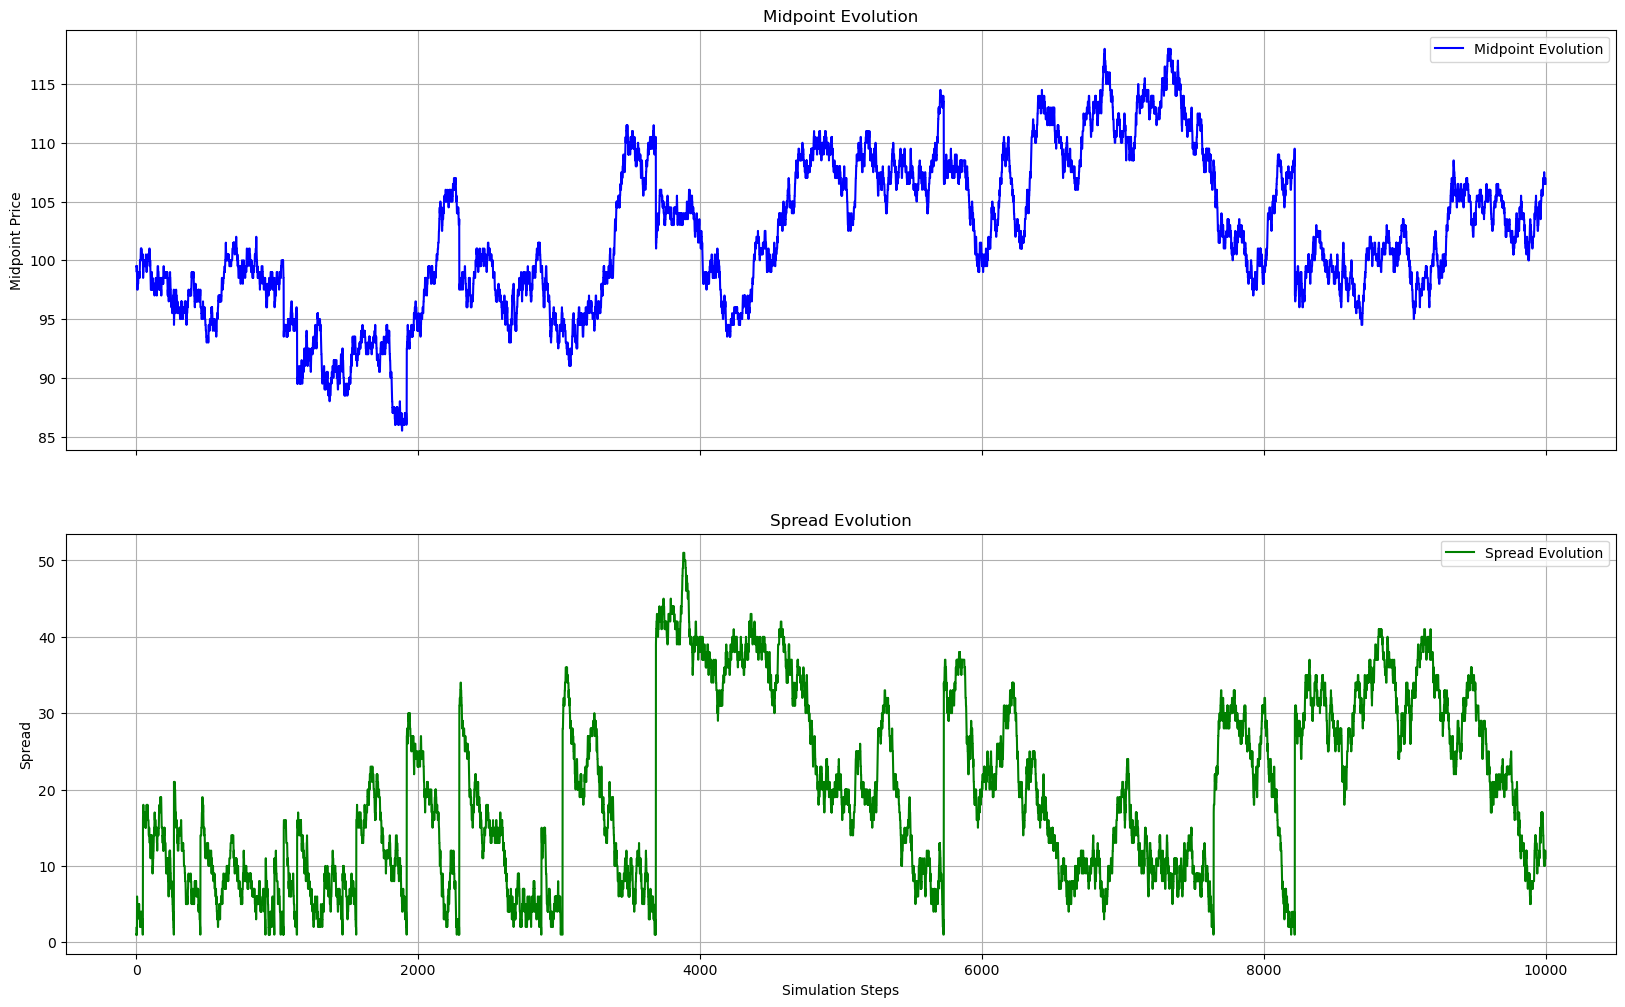

In [11]:
# Plot the timeseries of midprice and spread
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Plot midprice evolution
ax1.plot(mp_array, label='Midpoint Evolution', color='blue')
ax1.set_title('Midpoint Evolution')
ax1.set_ylabel('Midpoint Price')
ax1.legend()
ax1.grid(True)

# Plot spread evolution
ax2.plot(spread_array, label='Spread Evolution', color='green')
ax2.set_title('Spread Evolution')
ax2.set_xlabel('Simulation Steps')
ax2.set_ylabel('Spread')
ax2.legend()
ax2.grid(True)

The time series looks persistent and very volatilie.

In [12]:
# Print the estimated Hurst exponent for midprice and spread
print(f'Hurst Exponent for Midpoint (H): {H_mp:.4f}')
print(f'Hurst Exponent for Spread (H): {H_spread:.4f}')

Hurst Exponent for Midpoint (H): 0.4564
Hurst Exponent for Spread (H): 0.3733


### Q6: Plot also the histogram.

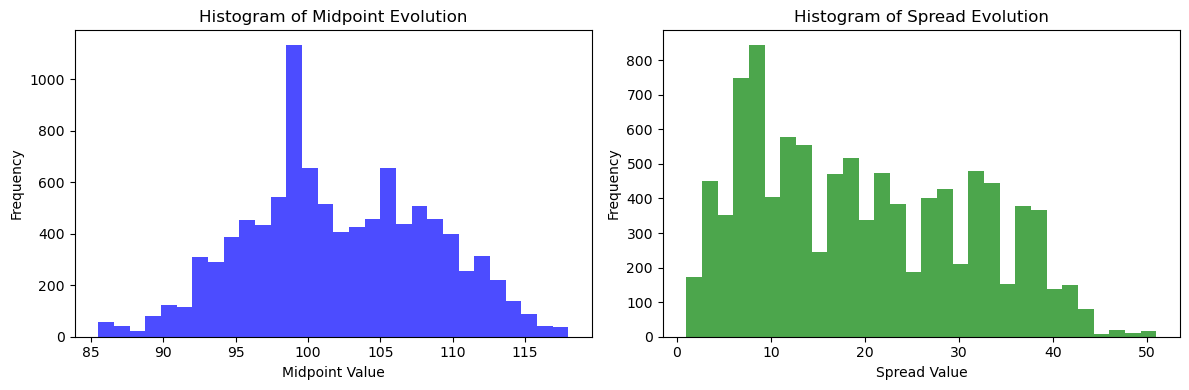

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(mp_evol, bins=30, color='blue', alpha=0.7)
axs[0].set_title('Histogram of Midpoint Evolution')
axs[0].set_xlabel('Midpoint Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(spread_evol, bins=30, color='green', alpha=0.7)
axs[1].set_title('Histogram of Spread Evolution')
axs[1].set_xlabel('Spread Value')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

It is clear that the spread often takes values around 15.